In [ ]:
%pip install torch matplotlib seaborn rdkit

In [ ]:
%pip install git+https://github.com/EBjerrum/molvecgen

Импорты

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from molvecgen.vectorizers import SmilesVectorizer

Чтение данных

In [4]:
df = pd.read_csv('sibur_element_119_final_train_data80.csv')

Убираем выбросы

In [ ]:
...

Переведём в класс молекул все примеры

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

In [6]:
print(df.shape)
df[["SMILES","Molecule"]].head()

(13403, 4)


,SMILES,Molecule
0,C1(NON=C1C2=CC=CC=C2)=N,<rdkit.Chem.rdchem.Mol object at 0x7a4a8bd4e650>
1,C=1C=CC=CC=1CC(NC=2C=CC(=CC=2)Br)=O,<rdkit.Chem.rdchem.Mol object at 0x7a4a8bd4dc40>
2,C(C)C1=CC=CS1,<rdkit.Chem.rdchem.Mol object at 0x7a4a8bb31000>
3,N1C=CNC1=NC2C(OC)=NC(=NC2Cl)C,<rdkit.Chem.rdchem.Mol object at 0x7a4a8bb31fc0>
4,CC(C)CCO,<rdkit.Chem.rdchem.Mol object at 0x7a4a8bb30200>


Убираем Nan после конвертации

In [7]:
df = df.dropna()
print(df.shape)

(12953, 4)


Обучаем векторизатор

In [8]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df.Molecule.values, )

Разделяем переменные

In [9]:
y = df['LogP'].values.reshape((-1,1))
X = df.Molecule.values

Разделяем выборки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)

Делаем нормализацию данных

In [11]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

Размеры

In [12]:
print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

(8289, 1)
(2073, 1)
(2591, 1)


Класс для датасета

In [13]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]

        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

Оборачиваем данные в класс датасета

In [14]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[78]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([-0.60517747]))

Переводим валидационные данные в тензоры

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
y_validation_t = torch.nan_to_num(y_validation_t, nan = torch.nanmean(y_validation_t))
X_validation_t.shape

cuda:0


torch.Size([2073, 168, 36])

Определяем параметры для модели

In [31]:
epochs = 100
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.3 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64  # The mini_batch size during training
learning_rate = 0.01  # The initial learning rate for the optimizer

Определяем модель

In [32]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]


        self.lstm = nn.GRU(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False, dropout  = 0.2)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size//2) # Output layer
        self.activation2 = nn.ReLU() # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(hidden_size//2, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):# Forward pass: stacking each layer together
        #out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out, h_n = self.lstm(x) #GRU network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.fc2(out) # Pass into the hidden layer
        out = self.activation2(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

Определяем экземпляр модели

In [33]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Net(
  (lstm): GRU(36, 32, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (activation2): ReLU()
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Пробуем сделать прямой проход в нейронке

In [34]:
pred = model.forward(X_validation_t[10:11])
pred

tensor([[[-0.2133]]], device='cuda:0', grad_fn=<ViewBackward0>)

Объявляем функцию потерь, оптимизатор и lr управление

In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


Создаём трейн лоадер из которого будем брать данные для обучения

In [36]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=4)

Проверка что лоадер возвращает примеры

In [ ]:
for smiles, labels in train_loader:
    print(smiles)
    print(labels)
    break

Обучаем модель

In [38]:
import warnings
warnings.filterwarnings('ignore')

model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        # Push numpy to CUDA tensors
        smiles = torch.tensor(smiles, device=device).float()
        #print(smiles)
        labels = torch.tensor(labels, device=device).float()
        labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))
        #print(labels)
        #break
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:


        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()

        lr_scheduler.step(validation_loss)

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%5 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))


Epoch 5, Training loss: 0.55 Validation loss: 0.49
Epoch 10, Training loss: 0.52 Validation loss: 0.44
Epoch 15, Training loss: 0.49 Validation loss: 0.46
Epoch 20, Training loss: 0.50 Validation loss: 0.42
Epoch 25, Training loss: 0.48 Validation loss: 0.42
Epoch 30, Training loss: 0.49 Validation loss: 0.41
Epoch 35, Training loss: 0.48 Validation loss: 0.41
Epoch 40, Training loss: 0.47 Validation loss: 0.39
Epoch 45, Training loss: 0.46 Validation loss: 0.41
Epoch 50, Training loss: 0.46 Validation loss: 0.44
Epoch 55, Training loss: 0.46 Validation loss: 0.40
Epoch 60, Training loss: 0.45 Validation loss: 0.39
Epoch 65, Training loss: 0.45 Validation loss: 0.39
Epoch 70, Training loss: 0.46 Validation loss: 0.38
Epoch 75, Training loss: 0.45 Validation loss: 0.42
Epoch 80, Training loss: 0.45 Validation loss: 0.39
Epoch 85, Training loss: 0.44 Validation loss: 0.38
Epoch 90, Training loss: 0.45 Validation loss: 0.39
Epoch 95, Training loss: 0.46 Validation loss: 0.39
Epoch 100, Tr

Смотрим графики функции потерь

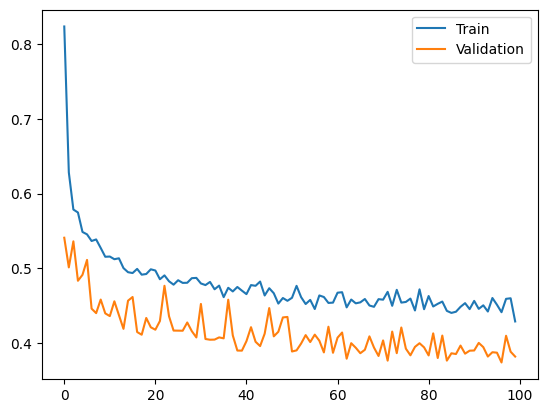

In [39]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

Смотрим ошибку на валидационной выборке

In [40]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
y_pred_validation = model(X_validation_t)
#y_pred_test = model(X_test)
torch.mean(( y_validation_t - y_pred_validation )**2).item()

0.38226550817489624

Переводим обучающую и тестовую выюорки в тензоры

In [41]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
y_train_t = torch.nan_to_num(y_train_t, nan = torch.nanmean(y_train_t))
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()
y_test_t = torch.nan_to_num(y_test_t, nan = torch.nanmean(y_test_t))

Делаем предсказание на трейне и тесте, считаем метрики

In [42]:
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.368	Test RMSE: 0.527


Сформируем сабмит

In [44]:
test_df = pd.read_csv('sibur_element_119_final_test_data80.csv')

In [50]:
test_df.shape

(2630, 3)

Превратим в молекулы записи тестового датасета

In [45]:
PandasTools.AddMoleculeColumnToFrame(test_df,'SMILES','Molecule')

Переведём в тензоры

In [48]:
X_test_t = smivec.transform(test_df['Molecule'], canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()

Сделаем предсказание

In [49]:
y_pred_test = model(X_test_t)
y_pred_test.shape

torch.Size([1, 2630, 1])

Превратим в лист

In [60]:
pred_test_list = y_pred_test[0].tolist()

Сделаем обратное преобразование и запишем в датафрейм

In [63]:
submit = test_df[['ID']]
submit['LogP'] = scaler.inverse_transform(pred_test_list).reshape(len(y_pred_test[0]), )
submit.head()

,ID,LogP
0,13403,3.140683
1,13404,3.877001
2,13405,5.531836
3,13406,3.093252
4,13407,5.707138


Сохраним

In [64]:
submit.to_csv('submit.csv', index=0)